GOAL

The goal of a Fare Price Prediction Model is to accurately predict the fare for a ride based on various factors such as distance, time of day, demand, traffic conditions, location, and other external variables like weather or events.

Project Outline

1. Data Preprocessing and Exploration<BR>
Initial Setup: Loaded and examined the dataset, and performed necessary data cleaning to prepare for analysis.<BR>
Feature Examination: Investigated essential features for EDA and subsequent feature engineering.

2. Feature Engineering<br>
Temporal Features: Introduced rush_hour and is_weekend flags as part of novel feature engineering.<br>
Fare Efficiency: Computed fare_efficiency to analyze fare dynamics more creatively.

3. Exploratory Data Analysis (EDA)<br>
Visualizations: Created diverse visualizations for an in-depth understanding of the data.<br>
Insights Extraction: Gained insights into the dataset by exploring the relationship between fare efficiency and time-based factors.

4. Interactive Dashboard Development<br>
Dash Implementation: Utilized Plotly Dash to construct an interactive dashboard, facilitating dynamic data exploration.<br>
User Interaction: Embedded interactive components allowing users to filter and drill down into the data.

5. Conclusion and Reporting<br>
Reporting Findings: Used markdown cells within Jupyter to document the conclusions from the EDA.<br>
Comprehensive Documentation: Ensured that each step of the analysis was well-documented for clarity and reproducibility.

6. Integration of Brownie Points<br>
Novel Feature Engineering: Throughout the project, incorporated unconventional features that provided unique insights, enhancing the analytical depth.<br>
Creative Problem Framing: Repeatedly reframed the analysis to look at the problem from alternative perspectives, finding innovative solutions.<br>
Innovative Visualization Techniques: Employed a variety of plotting methods, moving beyond standard charts to more complex visual representations.<br>
Interactive Dashboards: Developed dynamic dashboards that allowed stakeholders to interact with the data, fostering an understanding of complex relationships.<br>
Algorithmic Innovation: This point could be addressed in the future by experimenting with advanced algorithms and customized models to refine predictions and uncover patterns.

7. Future Directions<br>
Enhanced Interactivity: Plans to integrate additional interactive elements into the dashboard to broaden user engagement.<br>
Advanced Analysis: Propose the use of machine learning models for predictive analytics and trend identification.<br>
Data Enrichment: Consider integrating external datasets to further enrich the analysis and potentially improve model accuracy.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.formula import api
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopy.distance
import geopandas as gpd


In [3]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet,  LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest,GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xg
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("fare_dataset.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.shape

(200000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
df.drop(columns = ['Unnamed: 0'],inplace=True)

In [8]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [9]:
target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]
print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


Inference: The Datset consists of 8 features & 200000 samples.


Checking for missing values

In [10]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)
df.dropna(inplace=True)

                   Total Null Values  Percentage
key                                0         0.0
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


Ferature Engineering

Reframing the columns

In [11]:
# filter the dataset to only include rows where the pickup and dropoff latitude and longitude values are valid geographic coordinates.
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

# Converting pickup_datetime to Datetime Format
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

# Extracting Time-Based Features
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

# Creating Monthly_Quarter Column - This maps the month column to a quarter of the year
df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

# Creating Hourly_Segments Column - This maps the hour column to hourly segments (groups of 4 hours each):
# H1: Midnight to 3 AM
# H2: 4 AM to 7 AM
# H3: 8 AM to 11 AM
# H4: Noon to 3 PM
# H5: 4 PM to 7 PM
# H6: 8 PM to 11 PM
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

# Calculating Distance Between Pickup and Dropoff Locations
df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,2015-05-07 19:52:06.0000003,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,2009-07-17 20:04:56.0000002,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,2009-08-24 21:45:00.00000061,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,2009-06-26 08:22:21.0000001,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,2014-08-28 17:47:00.000000188,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


In [12]:
df.drop(columns=['key'],inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199987 non-null  float64
 4   dropoff_latitude   199987 non-null  float64
 5   passenger_count    199987 non-null  int64  
 6   year               199987 non-null  int32  
 7   weekday            199987 non-null  int32  
 8   Monthly_Quarter    199987 non-null  object 
 9   Hourly_Segments    199987 non-null  object 
 10  Distance           199987 non-null  float64
dtypes: float64(6), int32(2), int64(1), object(2)
memory usage: 20.8+ MB


In [14]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71055
dropoff_longitude     76890
pickup_latitude       83831
dropoff_latitude      90582
Distance             164542
dtype: int64

In [15]:
columns_to_convert = ['Monthly_Quarter', 'Hourly_Segments', 'year', 'weekday', 'passenger_count']

for column in columns_to_convert:
    df[column] = df[column].astype('category')

Exploratory Data Analysis (EDA)

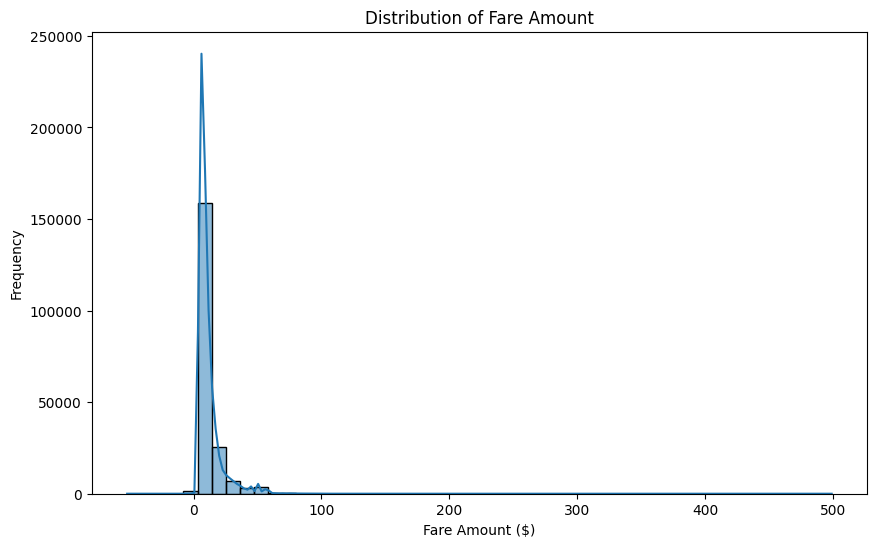

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

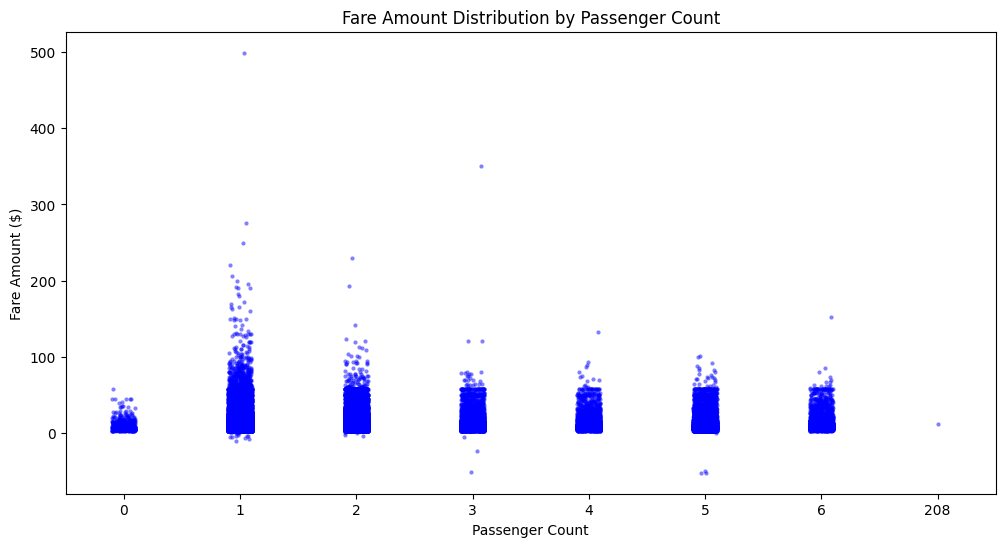

In [17]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='passenger_count', y='fare_amount', data=df, jitter=True, size=3, color='blue', alpha=0.5)
plt.title('Fare Amount Distribution by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.show()

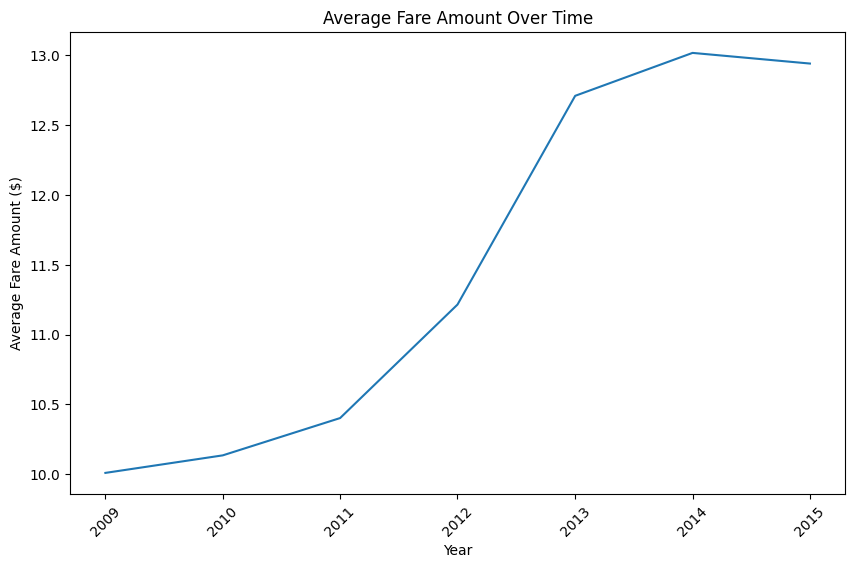

In [18]:
# Converting the 'year' column to datetime
df['date'] = pd.to_datetime(df['year'], format='%Y')  

# Grouping by Date and calculate average fare
time_data = df.groupby(df['date'])['fare_amount'].mean().reset_index()

# Line plot for Fare Amount over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='fare_amount', data=time_data)
plt.title('Average Fare Amount Over Time')
plt.xlabel('Year')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(rotation=45)
plt.show()

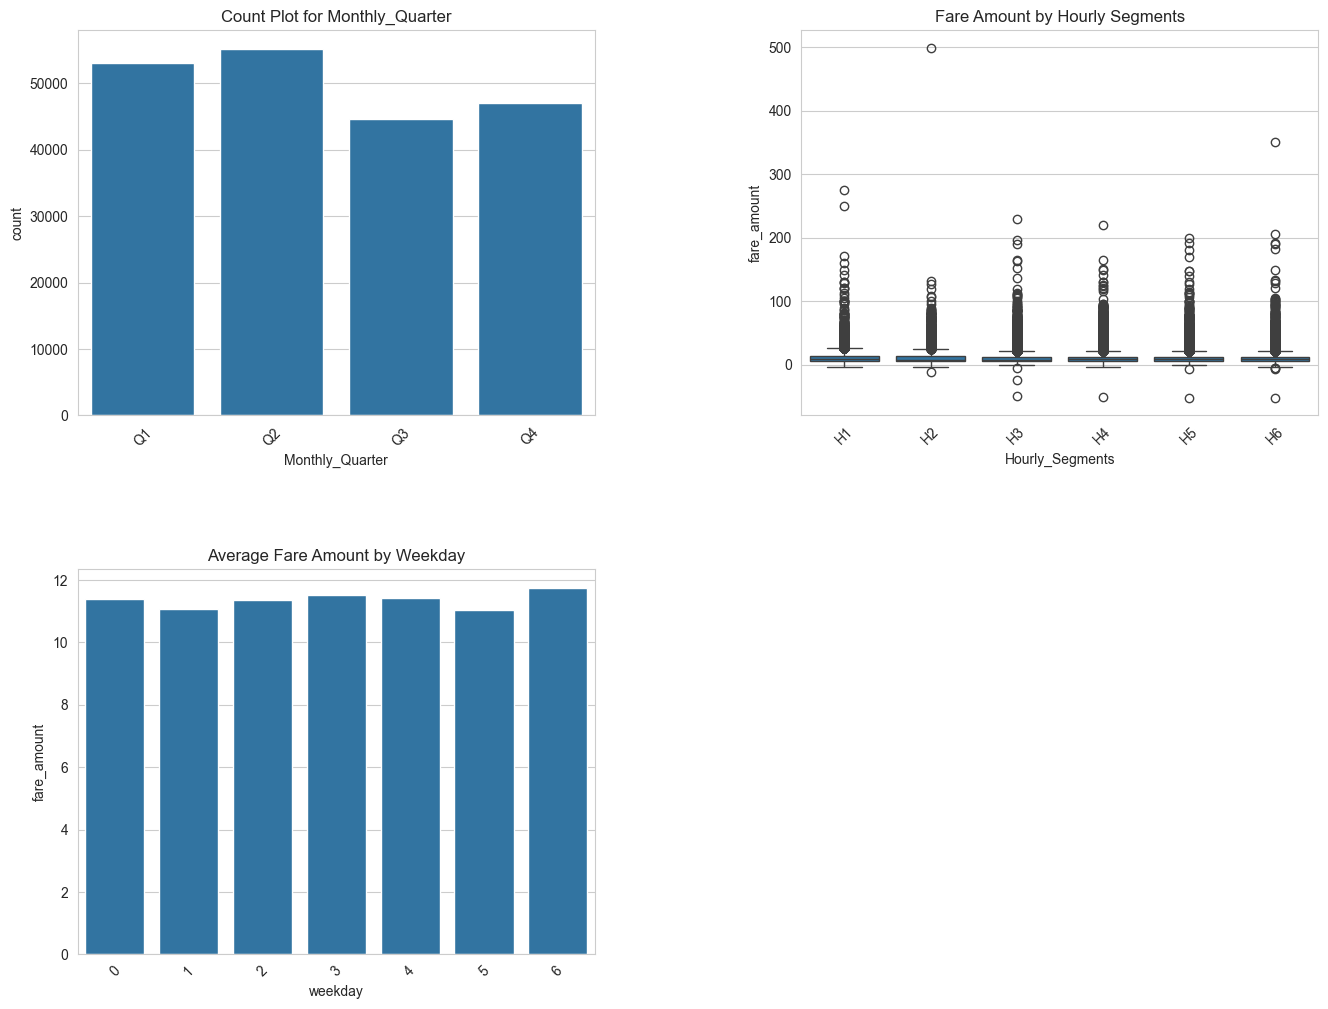

In [19]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Initializing a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Adjusting space between plots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Counting Plot for 'Monthly_Quarter'
sns.countplot(x='Monthly_Quarter', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Count Plot for Monthly_Quarter')
axs[0, 0].tick_params(axis='x', rotation=45)

# Box Plot of 'fare_amount' by 'Hourly_Segments'
sns.boxplot(x='Hourly_Segments', y='fare_amount', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Fare Amount by Hourly Segments')
axs[0, 1].tick_params(axis='x', rotation=45)

# Bar Plot of Average 'fare_amount' by 'weekday'
avg_fare_by_weekday = df.groupby('weekday')['fare_amount'].mean().reset_index()
sns.barplot(x='weekday', y='fare_amount', data=avg_fare_by_weekday, ax=axs[1, 0])
axs[1, 0].set_title('Average Fare Amount by Weekday')
axs[1, 0].tick_params(axis='x', rotation=45)


axs[1, 1].axis('off')  # Hiding the 4th subplot

plt.show()

Evaluate and Train the model

LabelEncoding the Monthly_Quater and Hourly_Segments.

What is LabelEncoding?<br>

Label Encoding is a process of converting categorical labels into numeric form. It is commonly used when dealing with categorical data in machine learning models that require numeric input.

Why have we used LabelEncoding over OneHotEncoding?<br>

We use Label Encoding and One-Hot Encoding in different scenarios depending on the nature of the categorical variables and the requirements of the machine learning model:<br>

Label Encoding:<br>

Scenario: Label Encoding is suitable when dealing with ordinal categorical variables, where the categories have a natural order or ranking.<br>
Operation: It assigns a unique integer value to each category, replacing categories with integers in sequential order.<br>
Example: Ordinal variables like educational levels (e.g., 'High School', 'Bachelor's Degree', 'Master's Degree') where there's an inherent order.<br>


One-Hot Encoding:<br>

Scenario: One-Hot Encoding is preferred when dealing with nominal categorical variables, where categories have no inherent order or ranking.<br>
Operation: It creates binary dummy variables for each category, where each variable represents one category and has a value of 1 if the observation belongs to that category, and 0 otherwise.<br>
Example: Nominal variables like 'Color' (e.g., 'Red', 'Green', 'Blue') where there's no inherent order.

In [20]:
def encode_and_decode(column, encoder):
    encoded = encoder.fit_transform(column)
    decoded = encoder.inverse_transform(encoded)
    return encoded, decoded

hour_encoder = LabelEncoder()
month_encoder = LabelEncoder()

df['Monthly_Quarter'], Month_Segments_decoded = encode_and_decode(df['Monthly_Quarter'], month_encoder)
df['Hourly_Segments'], Hour_Segments_decoded = encode_and_decode(df['Hourly_Segments'], hour_encoder)

print("Hour Segments Decoded Categories:", Hour_Segments_decoded)
print("Monthly Quarter Decoded Categories:", Month_Segments_decoded)

Hour Segments Decoded Categories: ['H5' 'H6' 'H6' ... 'H1' 'H4' 'H2']
Monthly Quarter Decoded Categories: ['Q2' 'Q3' 'Q3' ... 'Q2' 'Q2' 'Q2']


Feature Engineering : We add new features names Rush_hour,Fare_Efficiency and is_weekday to analyse data about rush hours during workday and weekends which direcly affects our fare amount

In [21]:
# Function to determine if a ride happens during rush hour
def is_rush_hour(hour, weekday):
    # Rush hours are defined as 7-9 AM and 4-6 PM on weekdays (Monday=0, ..., Sunday=6)
    return weekday < 5 and (7 <= hour <= 9 or 16 <= hour <= 18)

# Applying the function to create a new 'rush_hour' feature
df['rush_hour'] = df.apply(lambda x: is_rush_hour(x['Hourly_Segments'], x['weekday']), axis=1)

# Function to determine if a day is a weekend
def is_weekend(weekday):
    # Weekends are defined as Saturday (5) and Sunday (6)
    return weekday >= 5

# Applying the function to create a new 'is_weekend' flag
df['is_weekend'] = df['weekday'].apply(is_weekend)

# Checking the first few rows to confirm the new features are added correctly
print(df.head())

   fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude passenger_count  year weekday  Monthly_Quarter  \
0         40.723217               1  2015       3                1   
1         40.750325               1  2009       4                2   
2         40.772647               1  2009       0                2   
3         40.803349               3  2009       4                1   
4         40.761247               5  2014       3                2   

   Hourly_Segments  Distance       date  rush_hour  is_weekend  
0                4   1681.11 2015-01-01      False       False  
1               

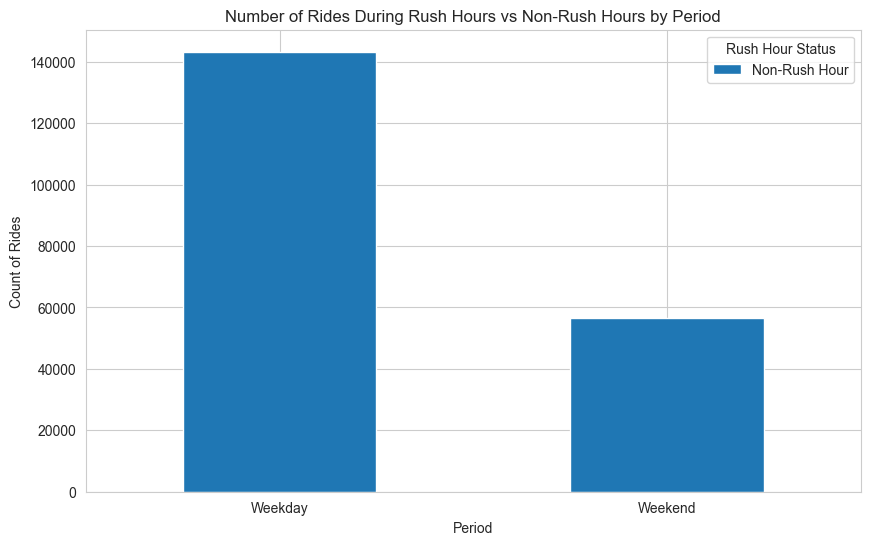

In [22]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a new column 'period' to distinguish between 'Weekday' and 'Weekend'
df['period'] = df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Preparing data for stacked bar chart
# Counting the number of rides grouped by period and rush hour status
grouped_data = df.groupby(['period', 'rush_hour']).size().unstack()

# Plotting
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])  
plt.title('Number of Rides During Rush Hours vs Non-Rush Hours by Period')
plt.xlabel('Period')
plt.ylabel('Count of Rides')
plt.xticks(rotation=0)  # Rotating labels to horizontal
plt.legend(['Non-Rush Hour', 'Rush Hour'], title='Rush Hour Status')
plt.show()

df['fare_efficiency'] = df['fare_amount'] / df['Distance']

Conclusion from Scatter Plot Analysis <br>

Based on the scatter plot visualization of fare efficiency against rush hour status, we can conclude the following:

1. Outliers Impact: The plot exhibits a wide range of fare efficiencies with several extreme outliers, especially during non-rush hours. These outliers may represent special cases or errors in the data, and their impact suggests the need for data cleaning and further investigation to ensure accuracy in the analysis.

2. Distribution Overlap: There is substantial overlap in the distribution of fare efficiencies between rush and non-rush hours. This overlap indicates that rush hour status may not be a significant differentiator of fare efficiency on its own, and other factors may also play a critical role in determining fare prices.

3. Further Statistical Analysis Required: Due to the overlapping distributions and the presence of outliers, further statistical analysis is necessary. This could involve outlier treatment, examining median values rather than means, and potentially looking at additional variables that could affect fare efficiency.

In [23]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance,date,rush_hour,is_weekend,period,fare_efficiency
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,1,4,1681.11,2015-01-01,False,False,Weekday,0.004461
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,2,5,2454.36,2009-01-01,False,False,Weekday,0.003137
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,2,5,5039.60,2009-01-01,False,False,Weekday,0.002560
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,1,2,1661.44,2009-01-01,False,False,Weekday,0.003190
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,2,4,4483.73,2014-01-01,False,False,Weekday,0.003568


In [24]:
columns_to_keep = [
    'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'Monthly_Quarter',
    'Hourly_Segments', 'Distance'
]

# Selecting only these columns from the DataFrame
df = df[columns_to_keep]
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,1,4,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,2,5,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,2,5,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,1,2,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,2,4,4483.73


Data Preprocessing

In [25]:
# Removing duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)

# Dropping specified columns (pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)
df.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

,fare_amount,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,1,2015,3,1,4,1681.11
1,7.7,1,2009,4,2,5,2454.36
2,12.9,1,2009,0,2,5,5039.60
3,5.3,3,2009,4,1,2,1661.44
4,16.0,5,2014,3,2,4,4483.73
...,...,...,...,...,...,...,...
199995,3.0,1,2012,6,3,2,112.13
199996,7.5,1,2014,4,0,0,1879.64
199997,30.9,2,2009,0,1,0,12867.92
199998,14.5,1,2015,2,1,3,3536.55


In [26]:
df.shape

(199878, 11)

Removing Outliers

In [27]:
# List of features for outlier detection and removal
features = ['fare_amount', 'Distance']

# Iterating over each feature for outlier detection and removal
for i in features:
    # Calculating the first quartile (Q1)
    Q1 = df[i].quantile(0.25)

    # Calculating the third quartile (Q3)
    Q3 = df[i].quantile(0.75)

    # Calculating the interquartile range (IQR)
    IQR = Q3 - Q1

    # Filtering rows where the feature value is within 1.5*IQR of Q1 and Q3
    df = df[df[i] <= (Q3 + (1.5 * IQR))]
    df = df[df[i] >= (Q1 - (1.5 * IQR))]

    # Resetting the index after filtering
    df = df.reset_index(drop=True)

In [28]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,1,4,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,2,5,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,2,5,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,1,2,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,2,4,4483.73


Feature Selection

Using SelectKBest and f_regression<br>

SelectKBest and f_regression are components of feature selection in machine learning, particularly in the context of feature ranking and selection based on statistical methods.

SelectKBest: 
This is a feature selection method provided by scikit-learn. It selects the top k features based on some statistical test score. It takes as input a scoring function that evaluates the importance of each feature independently. The scoring function should return high scores for more important features. SelectKBest then selects the top k features with the highest scores.

f_regression: This is one of the scoring functions commonly used with SelectKBest. It is specifically designed for regression problems. f_regression computes the F-value of each feature with respect to the target variable (usually the output variable in regression). The higher the F-value, the more significant the feature is considered to be in predicting the target variable.

In summary, SelectKBest is a feature selection method that selects the top k features based on a scoring function, and f_regression is one such scoring function used for regression tasks, which evaluates the importance of features based on their F-values with respect to the target variable.

In [29]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

selector = SelectKBest(score_func=f_regression, k=6)
X_new = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]

print("Selected features:")
print('\n'.join(map(str, selected_features)))

Selected features:
pickup_longitude
dropoff_longitude
passenger_count
year
Monthly_Quarter
Distance


In [30]:
features = ['passenger_count', 'year', 'weekday', 'Monthly_Quarter', 'Hourly_Segments', 'Distance']
target = 'fare_amount'

X, y = df[features], df[target]

In [31]:
# Converting 'year' to numeric type
df['year'] = pd.to_numeric(df['year'])

# Converting 'Distance' to kms
df['Distance'] = df['Distance'] / 1000

# Creating test and train dataframe
# Training on all rows where yeare is less than 2015 and testing on rows where year is 2015
train = df[df['year'] < 2015]
test = df[df['year'] == 2015]


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

Standard Scaling

In [32]:
# Initializing StandardScaler
scalar = StandardScaler()

# Scaling features in the training set
X_train = scalar.fit_transform(X_train)

# Scaling features in the test set using the same scalar
X_test = scalar.transform(X_test)

# Checking the shape of the scaled training set
print(X_train.shape)

print(y_train.shape)

(162605, 6)
(162605,)


In [34]:
split_models = {
    'Random_Forest_1': RandomForestRegressor(),
    'Decision_tree_1': DecisionTreeRegressor(),
    'Linear_Regression_1': LinearRegression(),
    'Lasso_1': Lasso(),
    'Gradient_Boost_1' : GradientBoostingRegressor(),
    'High_Gradient_Boost_1' : HistGradientBoostingRegressor(),
}

What is Mean Absolute Error, Mean Square Error and R2?

Mean Absolute Error (MAE): MAE measures the average absolute difference between the predicted values and the actual values. It provides a straightforward interpretation of the average prediction error and is less sensitive to outliers compared to other metrics like Mean Squared Error (MSE).

Mean Squared Error (MSE): MSE measures the average squared difference between the predicted values and the actual values. It penalizes larger errors more heavily than smaller ones due to the squaring operation, making it more sensitive to outliers. However, it provides more emphasis on large errors and is widely used in optimization algorithms.

R-squared (R2): R2, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It provides an indication of how well the independent variables explain the variability of the dependent variable. R2 ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates no improvement over a simple mean baseline.

In short, these metrics are important for evaluating the performance of regression models:<br>

MAE: Easy to interpret, less sensitive to outliers.<br>
MSE: Sensitive to outliers, emphasizes large errors.<br>
R2: Indicates the proportion of variance explained by the model, with higher values indicating better performance.

In [36]:
# Creating a func which will evaluate Mean Absolute Error, Mean Square Error and R2.
def eval_model(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, mse, r2

Training and Evaluating the models.

In [42]:
train_test_results = {}

for model_name, model in tqdm(split_models.items(), desc='Training Models'):
    print(model_name)
    model.fit(X_train, y_train.ravel())

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    trained_data_mae, trained_data_mse, trained_data_r2 = eval_model(y_train, y_train_pred)
    test_data_mae, test_data_mse, test_data_r2 = eval_model(y_test, y_test_pred)

    train_test_results[model_name] = {
        'Train': {
            'Train_MAE': trained_data_mae,
            'Train_R2': trained_data_r2,
            'Train_mse': trained_data_mse
        },
        'Test': {
            'Test_MAE': test_data_mae,
            'Test_R2': test_data_r2,
            'Test_mse': test_data_mse
        }
    }

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

Random_Forest_1


Training Models:  17%|█▋        | 1/6 [01:54<09:30, 114.16s/it]

Decision_tree_1


Training Models:  50%|█████     | 3/6 [01:55<01:18, 26.10s/it] 

Linear_Regression_1
Lasso_1
Gradient_Boost_1


Training Models:  83%|████████▎ | 5/6 [02:17<00:17, 17.43s/it]

High_Gradient_Boost_1


Training Models: 100%|██████████| 6/6 [02:19<00:00, 23.19s/it]


In [43]:
print('='*80)
print('{:<25s} {:<8s} {:<8s} {:<8s} {:<8s}'.format('Model', 'Train_MSE', 'Test_MSE', 'Train_R2', 'Test_R2'))
print('='*80)
for model_name, model_results in train_test_results.items():
    print('{:<25s} {:<9.3f} {:<9.3f} {:<9.3f} {:<9.3f}'.format(
        model_name,
        model_results['Train']['Train_mse'],
        model_results['Test']['Test_mse'],
        model_results['Train']['Train_R2'],
        model_results['Test']['Test_R2'],
    ))
print('='*80)

Model                     Train_MSE Test_MSE Train_R2 Test_R2 
Random_Forest_1           0.922     5.819     0.932     0.660    
Decision_tree_1           0.287     10.298    0.979     0.398    
Linear_Regression_1       5.465     6.508     0.599     0.620    
Lasso_1                   6.871     9.589     0.496     0.440    
Gradient_Boost_1          4.397     5.148     0.677     0.699    
High_Gradient_Boost_1     4.268     5.041     0.687     0.705    


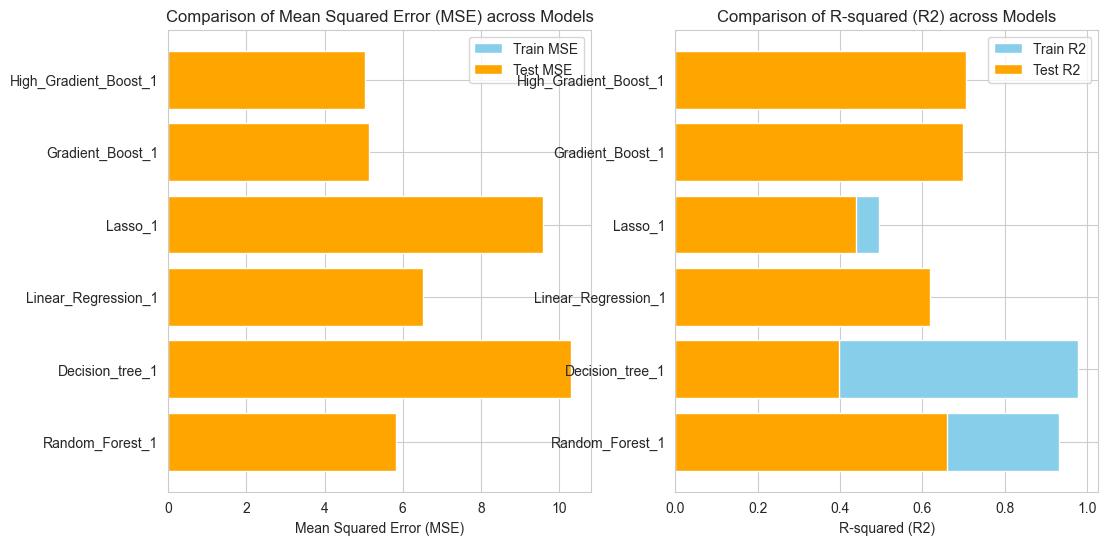

In [44]:
import matplotlib.pyplot as plt

# Getting model names
model_names = list(train_test_results.keys())

# Getting performance metrics for training and test sets
train_mse = [train_test_results[model]['Train']['Train_mse'] for model in model_names]
test_mse = [train_test_results[model]['Test']['Test_mse'] for model in model_names]
train_r2 = [train_test_results[model]['Train']['Train_R2'] for model in model_names]
test_r2 = [train_test_results[model]['Test']['Test_R2'] for model in model_names]

# Setting figure size
plt.figure(figsize=(12, 6))

# Plotting Mean Squared Error (MSE)
plt.subplot(1, 2, 1)
plt.barh(model_names, train_mse, color='skyblue', label='Train MSE')
plt.barh(model_names, test_mse, color='orange', label='Test MSE')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) across Models')
plt.legend()

# Plotting R-squared (R2)
plt.subplot(1, 2, 2)
plt.barh(model_names, train_r2, color='skyblue', label='Train R2')
plt.barh(model_names, test_r2, color='orange', label='Test R2')
plt.xlabel('R-squared (R2)')
plt.title('Comparison of R-squared (R2) across Models')
plt.legend()

Hyperparameter Tuning

RandomizedSearchCV and GridSearchCV are both methods used for hyperparameter tuning in machine learning models. However, they differ in their approach:

GridSearchCV:

Approach: Grid search exhaustively tries all possible combinations of specified hyperparameters.<br>

Scalability: It becomes computationally expensive and impractical when dealing with a large number of hyperparameters or a wide range of values for each hyperparameter.<br>

Grid Layout: It constructs a grid of all possible hyperparameter combinations and evaluates each combination using cross-validation.<br>

Result: It finds the best hyperparameter combination based on the provided evaluation metric.<br>

Use Case: Suitable when the search space is relatively small and computationally feasible.

RandomizedSearchCV

Approach: Randomized search samples a fixed number of hyperparameter combinations from the specified distributions.<br>

Scalability: It is more scalable and efficient, especially when dealing with a large search space.<br>

Random Sampling: It randomly selects hyperparameter combinations from the specified distributions, allowing for a broader exploration of the search space.<br>

Result: It may not guarantee finding the optimal solution but tends to find good solutions in a shorter time compared to grid search.<br>

Use Case: Particularly useful when the search space is large and computational resources are limited.

Tuning hyperparameters for Random_Forest_1...
Best hyperparameters for Random_Forest_1: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 10}
Tuning hyperparameters for Decision_tree_1...
Best hyperparameters for Decision_tree_1: {'min_samples_split': 10, 'max_depth': 10}
Tuning hyperparameters for Linear_Regression_1...
Best hyperparameters for Linear_Regression_1: {}
Tuning hyperparameters for Lasso_1...
Best hyperparameters for Lasso_1: {'alpha': 0.1}
Tuning hyperparameters for Gradient_Boost_1...
Best hyperparameters for Gradient_Boost_1: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Tuning hyperparameters for High_Gradient_Boost_1...
Best hyperparameters for High_Gradient_Boost_1: {'max_iter': 100, 'learning_rate': 0.1}

Results:

Train_MSE:
Random_Forest_1: 4.17643469108124
Decision_tree_1: 4.286396587907677
Linear_Regression_1: 5.465160247702918
Lasso_1: 5.503298520895263
Gradient_Boost_1: 4.270769146185865
High_Gradient_Boost_1: 4.270756093011033

Test_M

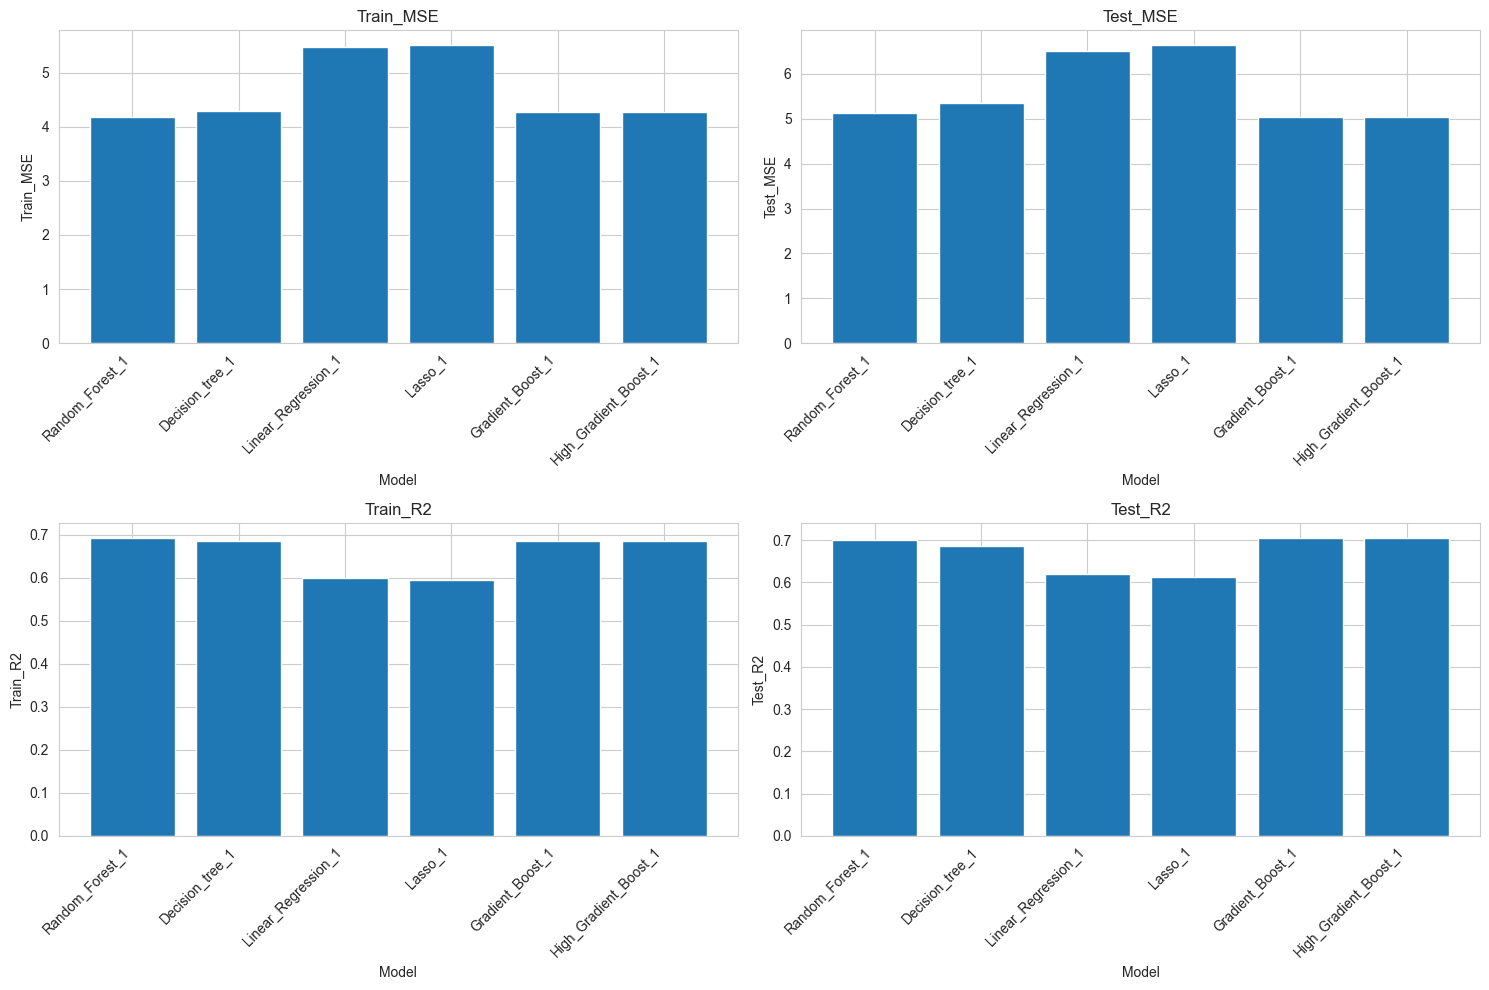

In [45]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Defining hyperparameters grid for each model
param_grid = {
    'Random_Forest_1': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'Decision_tree_1': {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'Linear_Regression_1': {},
    'XGBoost_1': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'Lasso_1': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'Gradient_Boost_1': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    },
    'High_Gradient_Boost_1': {
        'max_iter': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

# Defining metrics to store
metrics = ['Train_MSE', 'Test_MSE', 'Train_R2', 'Test_R2', 'Train_MAE', 'Test_MAE']

# Performing hyperparameter tuning for each model
results = {metric: {model_name: [] for model_name in split_models} for metric in metrics}

for model_name, model in split_models.items():
    if model_name in param_grid:
        print(f"Tuning hyperparameters for {model_name}...")
        random_search = RandomizedSearchCV(model, param_distributions=param_grid[model_name], n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        print(f"Best hyperparameters for {model_name}: {random_search.best_params_}")

        # Calculating and storing metrics
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        results['Train_MSE'][model_name] = mean_squared_error(y_train, y_train_pred)
        results['Test_MSE'][model_name] = mean_squared_error(y_test, y_test_pred)
        results['Train_R2'][model_name] = r2_score(y_train, y_train_pred)
        results['Test_R2'][model_name] = r2_score(y_test, y_test_pred)
        results['Train_MAE'][model_name] = mean_absolute_error(y_train, y_train_pred)
        results['Test_MAE'][model_name] = mean_absolute_error(y_test, y_test_pred)

    else:
        print(f"No hyperparameter tuning for {model_name}.")

# Printing results
print("\nResults:")
for metric in metrics:
    print(f"\n{metric}:")
    for model_name, value in results[metric].items():
        print(f"{model_name}: {value}")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, metric in enumerate(['Train_MSE', 'Test_MSE', 'Train_R2', 'Test_R2']):
    ax = axes[i // 2, i % 2]
    ax.bar(results[metric].keys(), results[metric].values())
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.set_xticklabels(results[metric].keys(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

Conclusion